In [61]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
from enlib import enmap,lensing as enlensing,fft
import numpy as np
from orphics import maps,io,stats,cosmology,lensing,symcoupling as sc


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
deg = 20.
px = 1.5
shape,wcs,modlmap,cc,mgen = maps.flat_sim(deg,px,lmax=6000,lensed=False,pol=False)

Generating theory Cls...


In [48]:
theory = cc.theory
lmax = modlmap.max()
ells = np.arange(0,lmax,1)
ps_kk = (theory.gCl('kk',ells)).reshape((1,1,ells.size))
noise_rms = 10.*np.pi/180./60.
beam = 1.5
ps_n = ps_kk*0.+noise_rms**2.
kgen = maps.MapGen(shape,wcs,ps_kk)
ngen1 = maps.MapGen(shape,wcs,ps_n*4.)
ngen2 = maps.MapGen(shape,wcs,ps_n*4.)
ngen3 = maps.MapGen(shape,wcs,ps_n*4.)
ngen4 = maps.MapGen(shape,wcs,ps_n*4.)

kbeam = maps.gauss_beam(modlmap,beam)

In [49]:
def lens(cmb,kappa):
    phi = lensing.kappa_to_phi(kappa,modlmap,return_fphi=False)
    grad_phi = enmap.grad(phi)
    return enlensing.lens_map(cmb, grad_phi, order=5, mode="spline", border="cyclic", trans=False, deriv=False, h=1e-7)

In [50]:
tellmin = 100
tellmax = 3000
kellmin = 20
kellmax = 2500

tmask = maps.mask_kspace(shape,wcs,lmin=tellmin,lmax=tellmax)
kmask = maps.mask_kspace(shape,wcs,lmin=kellmin,lmax=kellmax)


#qest_split = lensing.qest(shape,wcs,theory,noise2d=maps.interp(ells,ps_n.reshape(-1))(modlmap)*4.,beam2d=kbeam,kmask=tmask,noise2d_P=None,kmask_P=None,kmask_K=kmask,pol=False,grad_cut=None,unlensed_equals_lensed=True,bigell=9000)
n2dtt = maps.interp(ells,ps_n.reshape(-1))(modlmap)
qest_coadd = lensing.qest(shape,wcs,theory,noise2d=n2dtt,beam2d=kbeam,kmask=tmask,noise2d_P=None,kmask_P=None,kmask_K=kmask,pol=False,grad_cut=None,unlensed_equals_lensed=True,bigell=9000)

#qest_nonoise = lensing.qest(shape,wcs,theory,noise2d=modlmap*0.,beam2d=kbeam,kmask=tmask,noise2d_P=None,kmask_P=None,kmask_K=kmask,pol=False,grad_cut=None,unlensed_equals_lensed=True,bigell=9000)




In [51]:
mc = sc.LensingModeCoupling(shape,wcs)
AL = mc.AL("TT",tmask,tmask,n2dtt,0,0,theory=theory,hdv=True,cache=True)
cross = mc.cross("TT","TT",theory,tmask,tmask,noise_t=n2dtt,noise_e=0,noise_b=0,
                 ynoise_t=None,ynoise_e=None,ynoise_b=None,
                 cross_xnoise_t=0,cross_ynoise_t=0,
                 cross_xnoise_e=None,cross_ynoise_e=None,
                 cross_xnoise_b=None,cross_ynoise_b=None,
                 theory_norm=None,hdv=True,save_expression="current",validate=True,cache=True)

Nlpred = mc.NL(AL,AL,cross)

In [59]:
sl = lensing.SplitLensing(shape,wcs,qest_coadd)

In [68]:
Nsims = 10
bin_edges = np.linspace(kellmin,kellmax,40)

st = stats.Stats()

for i in range(Nsims):
    
    unlensed = mgen.get_map(seed=(i,1))
    kappa = kgen.get_map(seed=(i,2))
    lensed = maps.filter_map(lens(unlensed,kappa),kbeam)
    
    
    obs_split1 = lensed.copy() + ngen1.get_map(seed=(i,3))
    obs_split2 = lensed.copy() + ngen2.get_map(seed=(i,4))
    obs_split3 = lensed.copy() + ngen3.get_map(seed=(i,5))
    obs_split4 = lensed.copy() + ngen4.get_map(seed=(i,6))
    
    splits = np.stack([obs_split1,obs_split2,obs_split3,obs_split4])
    obs_coadd = np.mean(splits,axis=0)
    
    psplit = 0.
    
    ksplits = fft.fft(splits,axes=[-2,-1])
    psplit = maps.binned_power(sl.auto_free(ksplits,crosses=True),bin_edges=bin_edges)[1]
    
    #recon_split1 = enmap.enmap(qest_coadd.kappa_from_map("TT",obs_split1,T2DDataY=obs_split2),wcs)
    #recon_split2 = enmap.enmap(qest_coadd.kappa_from_map("TT",obs_split3,T2DDataY=obs_split4),wcs)
    #psplit += maps.binned_power(recon_split1,imap2=recon_split2,bin_edges=bin_edges)
    
    
    recon_coadd = enmap.enmap(qest_coadd.kappa_from_map("TT",obs_coadd),wcs)
    #recon_nonoise = enmap.enmap(qest_nonoise.kappa_from_map("TT",lensed),wcs)
    
    pcoadd = maps.binned_power(recon_coadd,bin_edges=bin_edges)
    #pnonoise = maps.binned_power(recon_nonoise,bin_edges=bin_edges)
    
    csplit1 = maps.binned_power(recon_split1,imap2=kappa,bin_edges=bin_edges)
    csplit2 = maps.binned_power(recon_split2,imap2=kappa,bin_edges=bin_edges)
    ccoadd =  maps.binned_power(recon_coadd,imap2=kappa,bin_edges=bin_edges)
    #cnonoise =  maps.binned_power(recon_nonoise,imap2=kappa,bin_edges=bin_edges)
    
    st.add_to_stats("splitp",psplit[1])
    st.add_to_stats("pcoadd",pcoadd[1])
    #st.add_to_stats("pnonoise",pnonoise[1])
    st.add_to_stats("csplit1",csplit1[1])
    st.add_to_stats("csplit2",csplit2[1])
    st.add_to_stats("ccoadd",ccoadd[1])
    #st.add_to_stats("cnonoise",ccoadd[1])
    
st.get_stats()
        

0
1
2
3
0.09375


AttributeError: 'tuple' object has no attribute 'shape'

ValueError: shape mismatch: objects cannot be broadcast to a single shape

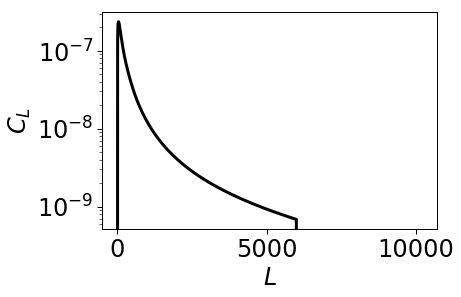

In [66]:
cents = psplit[0]

splitp = st.stats['splitp']['mean']
coaddp = st.stats['pcoadd']['mean']
esplitp = st.stats['splitp']['errmean']
ecoaddp = st.stats['pcoadd']['errmean']
esplitp1 = st.stats['splitp']['err']
ecoaddp1 = st.stats['pcoadd']['err']

clkk2d = maps.interp(ells,ps_kk.reshape(-1))(modlmap)
clkk1dbins = stats.bin_in_annuli(clkk2d,modlmap,bin_edges)[1]

nlkk_coadd2d = qest_coadd.N.Nlkk['TT']+clkk2d

nlkk_coadd = stats.bin_in_annuli(nlkk_coadd2d,modlmap,bin_edges)[1]

nlkk_pred = stats.bin_in_annuli(Nlpred+clkk2d,modlmap,bin_edges)[1]

pl = io.Plotter(yscale='log',xlabel='$L$',ylabel='$C_L$')
pl.add(ells,ps_kk.reshape(-1),lw=3,color='k')

pl.add(cents,nlkk_coadd,lw=2,ls="--",label='coadd',color="C1")

pl.add_err(cents,coaddp,yerr=ecoaddp,marker="o",ls="none",color="C1")
pl.add_err(cents,splitp,yerr=esplitp,marker="o",ls="none",color="C0")
pl.add(cents,nlkk_pred,lw=2,ls="-",label='split pred',color="C0")

pl.legend(loc='lower left')
pl._ax.set_xlim(0,3000)
pl._ax.set_ylim(3e-8,1e-6)
pl.done()

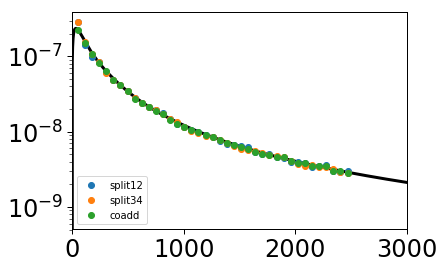

In [54]:

csplit1 = st.stats['csplit1']['mean']
csplit2 = st.stats['csplit2']['mean']
ccoadd = st.stats['ccoadd']['mean']
#cnonoise = st.stats['cnonoise']['mean']

pl = io.Plotter(yscale='log')
pl.add(ells,ps_kk.reshape(-1),lw=3,color='k')
pl.add(cents,csplit1,marker="o",ls="none",color="C0",label="split12")
pl.add(cents,csplit2,marker="o",ls="none",color="C1",label="split34")
pl.add(cents,ccoadd,marker="o",ls="none",color="C2",label="coadd")
#pl.add(cents,cnonoise,marker="o",ls="none",color="C3",label="nonoise")

pl.legend(loc='lower left')
pl._ax.set_xlim(0,3000)
pl.done()

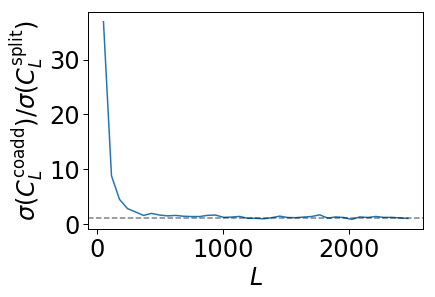

In [58]:
pl = io.Plotter(xlabel='$L$',ylabel='$\\sigma(C^{\\mathrm{coadd}}_L)/\\sigma(C^{\\mathrm{split}}_L)$')
pl.add(cents,esplitp1/ecoaddp1)
pl.hline(y=1)
pl.done()

In [56]:
def sn(clbins,errs):
    return np.sqrt(np.sum(clbins**2./errs**2.))

sncoadd = sn(clkk1dbins,ecoaddp1)
snsplit = sn(clkk1dbins,esplitp1)
print(sncoadd,snsplit,sncoadd/snsplit)

16.687666336774193 8.783967857735481 1.899786816965459
